# Import

In [1]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')
import holidays
import warnings
warnings.filterwarnings('ignore')
#Save requirements
os.system("pip freeze > requirements.txt")

0

In [2]:
df = pd.read_csv('Data/london_merged.csv')
display(df.head(2))

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0


- Metadata:
  - "timestamp" - timestamp field for grouping the data
  - "cnt" - the count of a new bike shares
  - "t1" - real temperature in C
  - "t2" - temperature in C "feels like"
  - "hum" - humidity in percentage
  - "wind_speed" - wind speed in km/h
  - "weather_code" - category of the weather
  - "is_holiday" - boolean field - 1 holiday / 0 non holiday
  - "is_weekend" - boolean field - 1 if the day is weekend
  - "season" - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.
  - "weathe_code" category description:
     - 1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 
     - 2 = scattered clouds / few clouds 
     - 3 = Broken clouds 
     - 4 = Cloudy 
     - 7 = Rain/ light Rain shower/ Light rain 
     - 10 = rain with thunderstorm 
     - 26 = snowfall 
     - 94 = Freezing Fog

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


# Data Wrangling

In [4]:
#Convert the timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
#Keep records from 2015 and 2016
df = df[(df['timestamp'].dt.year == 2015) | (df['timestamp'].dt.year == 2016)]
#Sort the values by timestamp
df = df.sort_values('timestamp')

In [5]:
#Missing values
df.isnull().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

- No missing values. But there might be missing timestamps.

In [6]:
#Check for missing timestamps
all_days = pd.date_range(start=df['timestamp'].min(), end=df['timestamp'].max(), freq='h')
missing_days = all_days[~all_days.isin(df['timestamp'])]
print('Number of missing timestamps:', len(missing_days))

Number of missing timestamps: 130


In [7]:
missing_days[0]

Timestamp('2015-01-07 19:00:00')

- 130 timestamps are missing. We will imput them using existing values.

In [8]:
#London holidays
uk_holidays = holidays.UK(years=[df['timestamp'].dt.year.min(), df['timestamp'].dt.year.max()])
uk_holidays

{datetime.date(2016, 3, 25): 'Good Friday', datetime.date(2016, 5, 2): 'May Day', datetime.date(2016, 5, 30): 'Spring Bank Holiday', datetime.date(2016, 1, 1): "New Year's Day", datetime.date(2016, 12, 25): 'Christmas Day', datetime.date(2016, 12, 27): 'Christmas Day (observed)', datetime.date(2016, 12, 26): 'Boxing Day', datetime.date(2015, 4, 3): 'Good Friday', datetime.date(2015, 5, 4): 'May Day', datetime.date(2015, 5, 25): 'Spring Bank Holiday', datetime.date(2015, 1, 1): "New Year's Day", datetime.date(2015, 12, 25): 'Christmas Day', datetime.date(2015, 12, 26): 'Boxing Day', datetime.date(2015, 12, 28): 'Boxing Day (observed)'}

In [9]:
#Create new dataframe using all days
df_full = pd.DataFrame(all_days, columns=['timestamp'])
#Merge with df to get cnt, t1, t2, hum, wind_speed, weather_code, season
df_full = df_full.merge(df[['timestamp', 'cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'season']], on='timestamp', how='left')
#is_holiday column: 1 if holiday, 0 if not
df_full['is_holiday'] = np.where(df_full['timestamp'].dt.date.isin(uk_holidays), 1, 0)
df_full['is_weekend'] = np.where(df_full['timestamp'].dt.dayofweek.isin([5, 6]), 1, 0)

#Backfill missing values
df_full = df_full.ffill()
df = df_full.copy()

In [10]:
df.isnull().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
season          0
is_holiday      0
is_weekend      0
dtype: int64

In [11]:
missing_days = all_days[~all_days.isin(df['timestamp'])]
print('Number of missing timestamps:', len(missing_days))

Number of missing timestamps: 0


In [12]:
#Set the timestamp as the index
df.set_index('timestamp', inplace=True)
#Set period to 1 hour
df.index = pd.DatetimeIndex(df.index).to_period('h')
df.head(2)

,cnt,t1,t2,hum,wind_speed,weather_code,season,is_holiday,is_weekend
timestamp,,,,,,,,,
2015-01-04 00:00,182.0,3.0,2.0,93.0,6.0,3.0,3.0,0,1
2015-01-04 01:00,138.0,3.0,2.5,93.0,5.0,1.0,3.0,0,1


Since the goal is to predict daily rentals, we will resample the data to daily frequency. This is where feature engineering is important. As an example of bad feature engineering, we will take the median of temperature, humidity, and wind speed for each day. For weather code and season, we will take the most frequent value. For holiday and weekend, we will take the maximum value since all the values will be same for each day. This way of feature engineering is not good because we are losing a lot of information with respect to time of day. For example, if it rains from 12 am to 8 am and then from 6 pm to 12 am, entire day is marked as rainy. Since most of the travel happens during the day, this is not a good representation of the data.  

In [13]:
df = df.resample('D').agg({'cnt':'sum', 
                           't1':'median', 
                           't2':'median', 
                           'hum':'median', 
                           'wind_speed':'median', 
                           'weather_code': lambda x: x.value_counts().index[0], 
                           'season': lambda x: x.value_counts().index[0], 
                           'is_holiday':'max', 
                           'is_weekend':'max'})
df.head(2)

,cnt,t1,t2,hum,wind_speed,weather_code,season,is_holiday,is_weekend
timestamp,,,,,,,,,
2015-01-04,9234.0,2.75,0.00,93.0,7.0,3.0,3.0,0,1
2015-01-05,20372.0,9.00,7.25,81.5,8.5,3.0,3.0,0,0


In [14]:
#Remove duplicates
df.drop_duplicates(inplace=True)

Index(['cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'season',
       'is_holiday', 'is_weekend'],
      dtype='object')


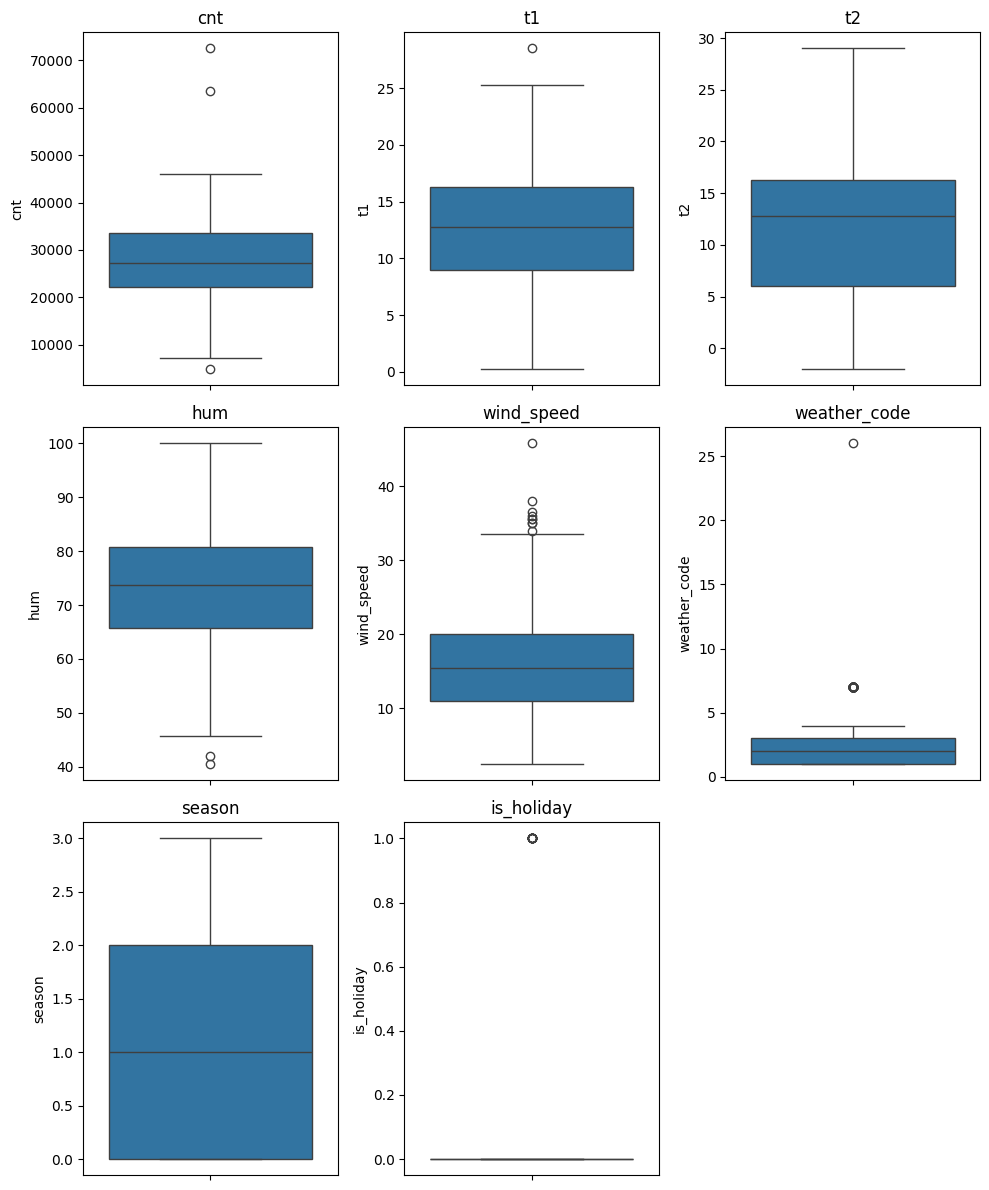

In [15]:
# # Boxplot of all the columns
plt.figure(figsize=(10, 12))
cols = df.columns
print(cols)
for i in range(1, len(cols)):
    plt.subplot(3, 3, i)
    sns.boxplot(df[cols[i-1]])
    plt.title(cols[i-1])
plt.tight_layout()
plt.show()

- There is no abnormal data in the dataset.

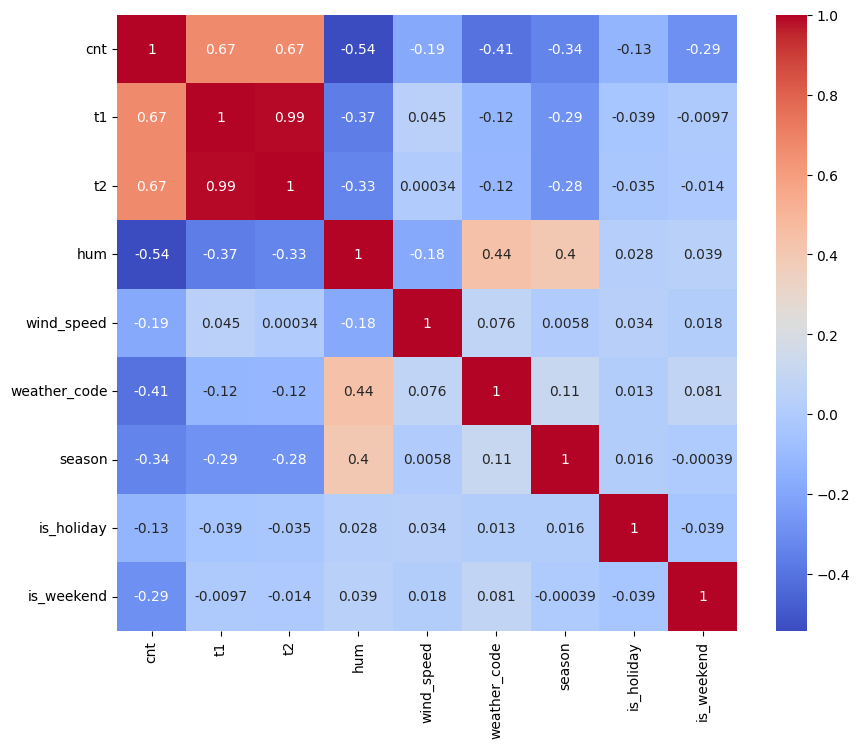

In [16]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

- Real and feels like temperature are highly correlated. Let's use feels like temperature since it is more likely to impact the decision.

In [17]:
#Drop t1
df.drop(['t1'], axis=1, inplace=True)

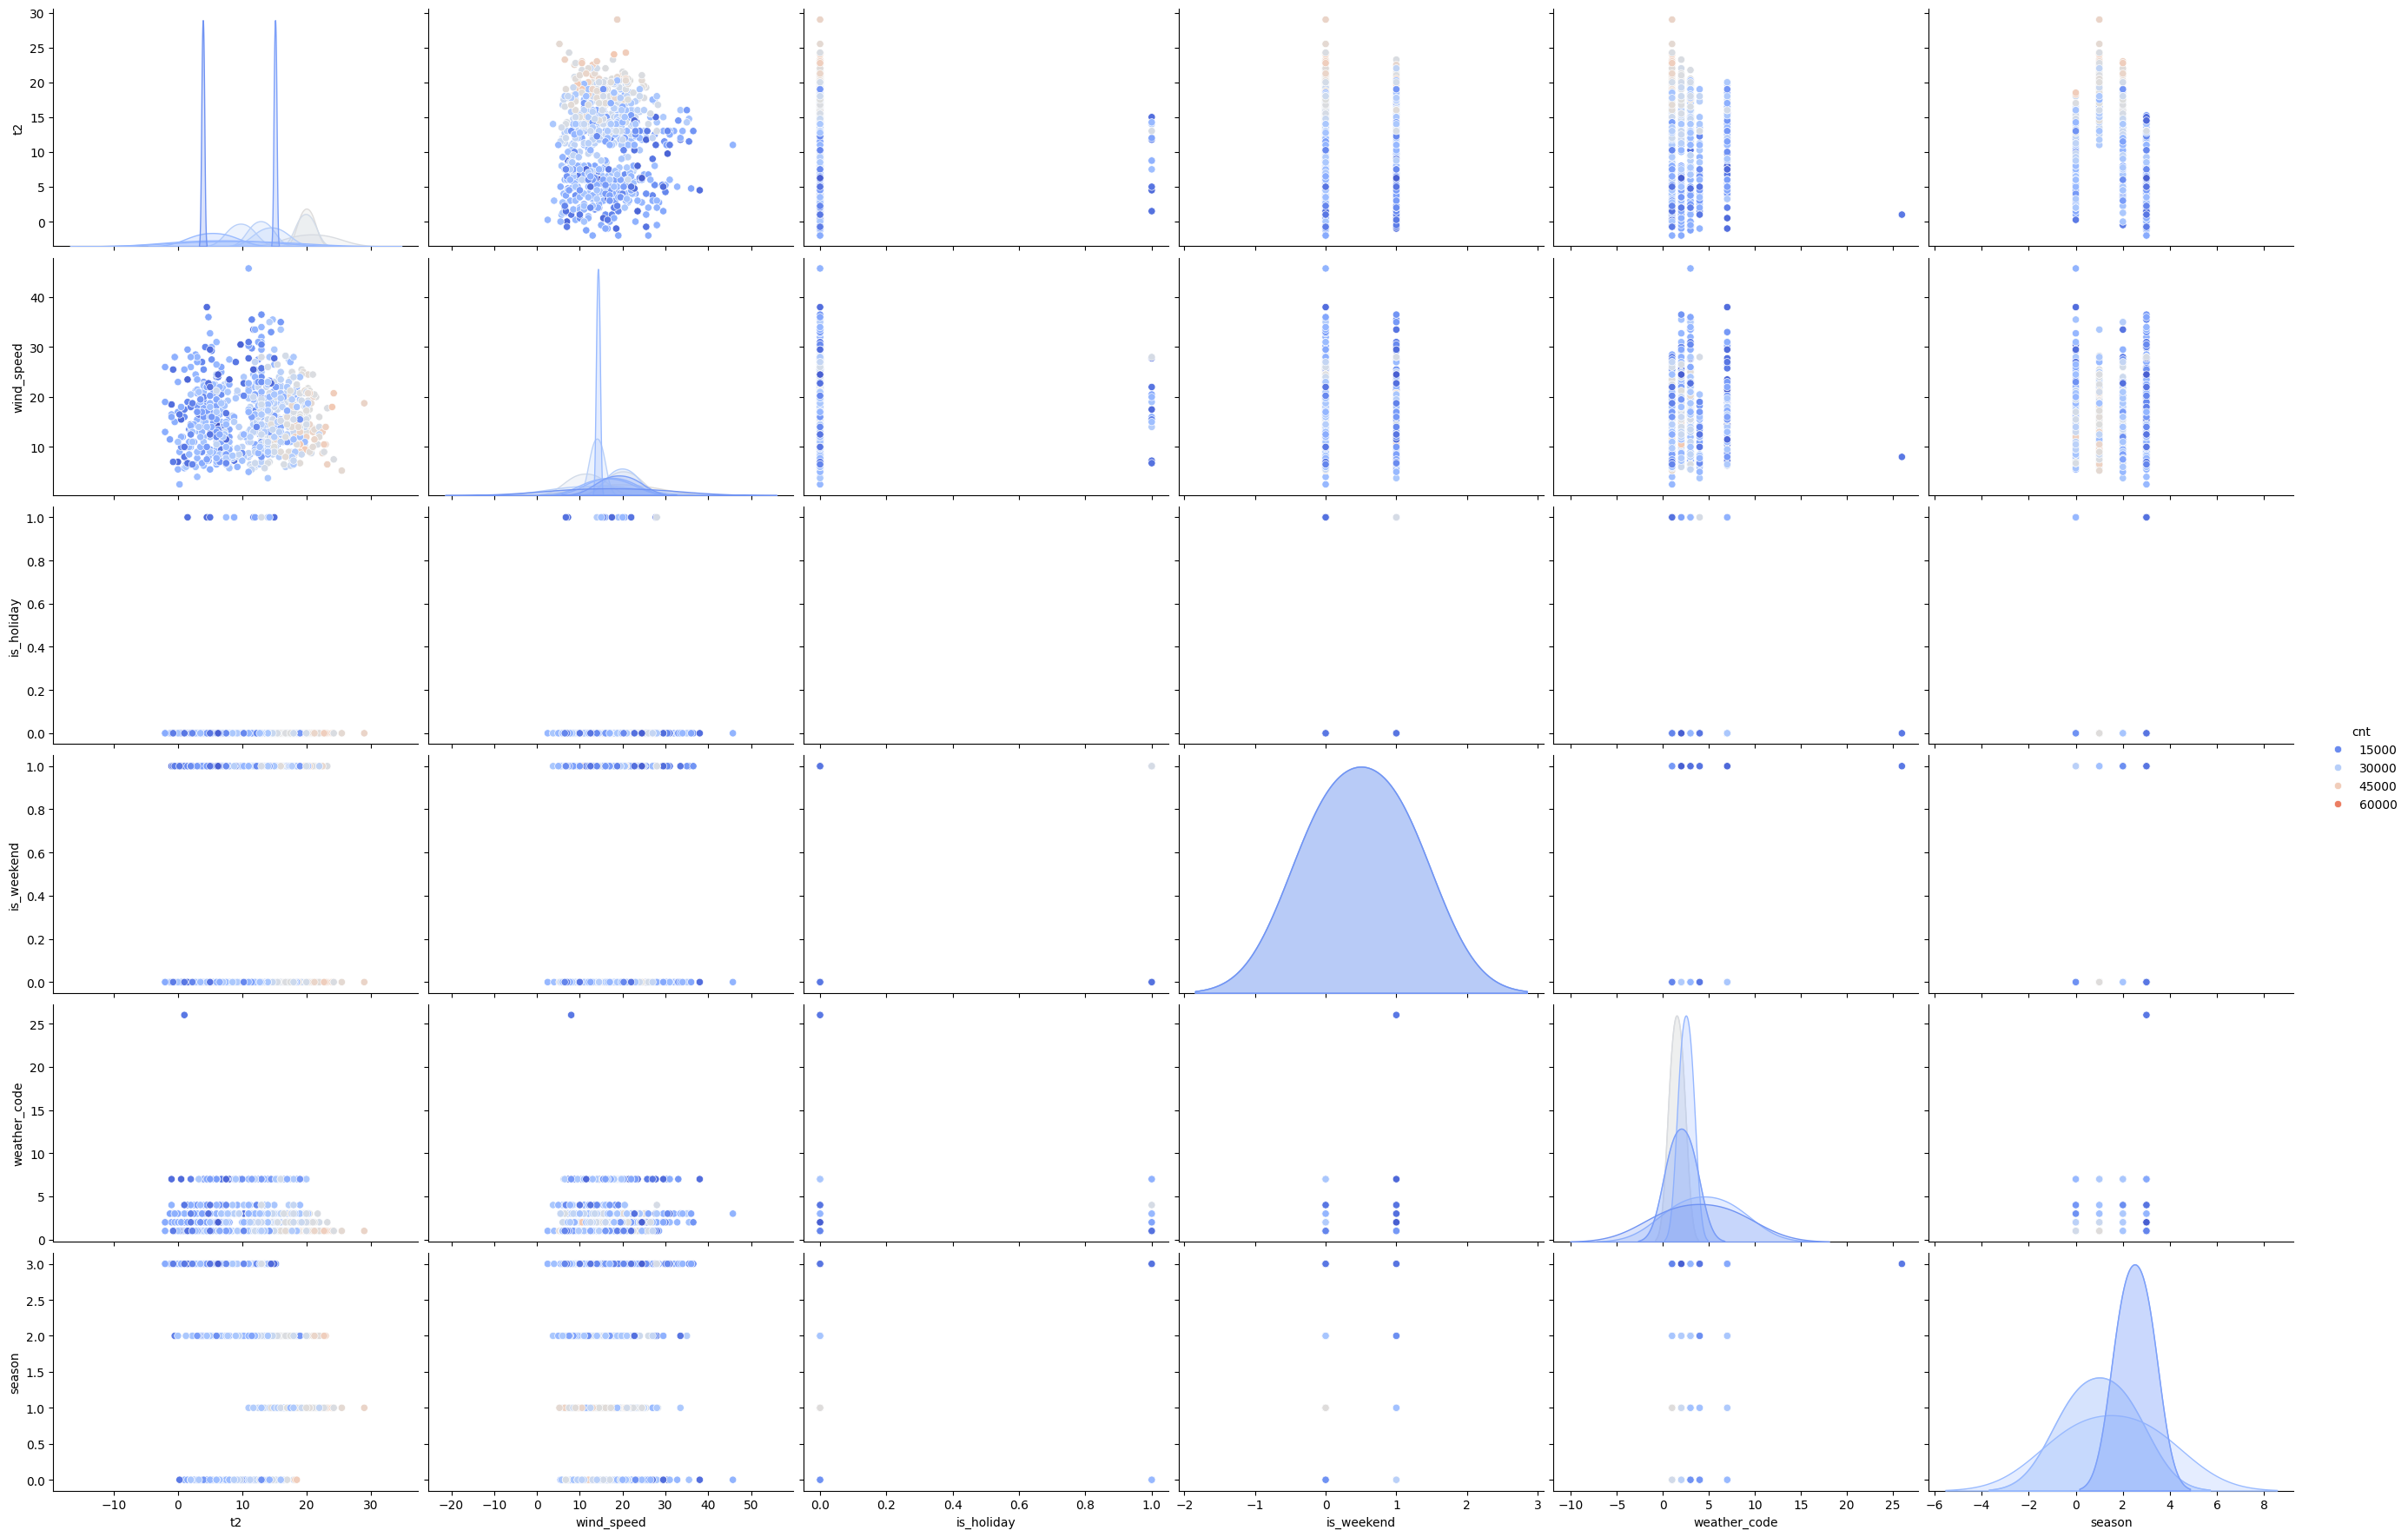

In [18]:
# #Pairplot
sns.pairplot(df[['cnt', 't2', 'wind_speed', 'is_holiday', 'is_weekend', 'weather_code',
                  'season',
                  ]],
             hue='cnt', 
             palette='coolwarm',
             height=3,
             aspect=1.5)
plt.show()

- Weekdays and Non holiday days with high temparature have more bike rentals.


In [19]:
#Map codes
#Map weather code:
weather_desc = {
    1: 'Clear', 2: 'Scattered_Clouds', 3: 'Broken_Clouds', 4: 'Cloudy', 7: 'Rain', 10: 'Storm', 26: 'Snowfall', 94: 'Freezing_Fog'
}
df['weather_code'] = df['weather_code'].map(weather_desc)
#Map season:
seasons = {0:'Spring', 1:'Summer', 2:'Fall', 3:'Winter'}
df['season'] = df['season'].map(seasons)
df.head(2)

,cnt,t2,hum,wind_speed,weather_code,season,is_holiday,is_weekend
timestamp,,,,,,,,
2015-01-04,9234.0,0.00,93.0,7.0,Broken_Clouds,Winter,0,1
2015-01-05,20372.0,7.25,81.5,8.5,Broken_Clouds,Winter,0,0


In [20]:
#One hot encoding for categorical variables
df = pd.get_dummies(df, drop_first=True, dtype=int)
df.head(2)

,cnt,t2,hum,wind_speed,is_holiday,is_weekend,weather_code_Clear,weather_code_Cloudy,weather_code_Rain,weather_code_Scattered_Clouds,weather_code_Snowfall,season_Spring,season_Summer,season_Winter
timestamp,,,,,,,,,,,,,,
2015-01-04,9234.0,0.00,93.0,7.0,0,1,0,0,0,0,0,0,0,1
2015-01-05,20372.0,7.25,81.5,8.5,0,0,0,0,0,0,0,0,0,1


In [21]:
# Add month sine and cosine columns
df['month_sin'] = np.sin(2*np.pi*df.index.month/12)
df['month_cos'] = np.cos(2*np.pi*df.index.month/12)

In [22]:
#Training df till June 2016 and testing df from July 2016
train_df = df.loc[:'2016-06-30'].copy()
test_df = df.loc['2016-07-01':].copy()

In [23]:
#In case some models need validation set, split train_df to get validation set. Use validation from April 2016 to June 2016. 
train_train_df = train_df.loc[:'2016-03-31'].copy()
val_df = train_df.loc['2016-04-01':].copy()

# Diagnosis

### Check for seasonality

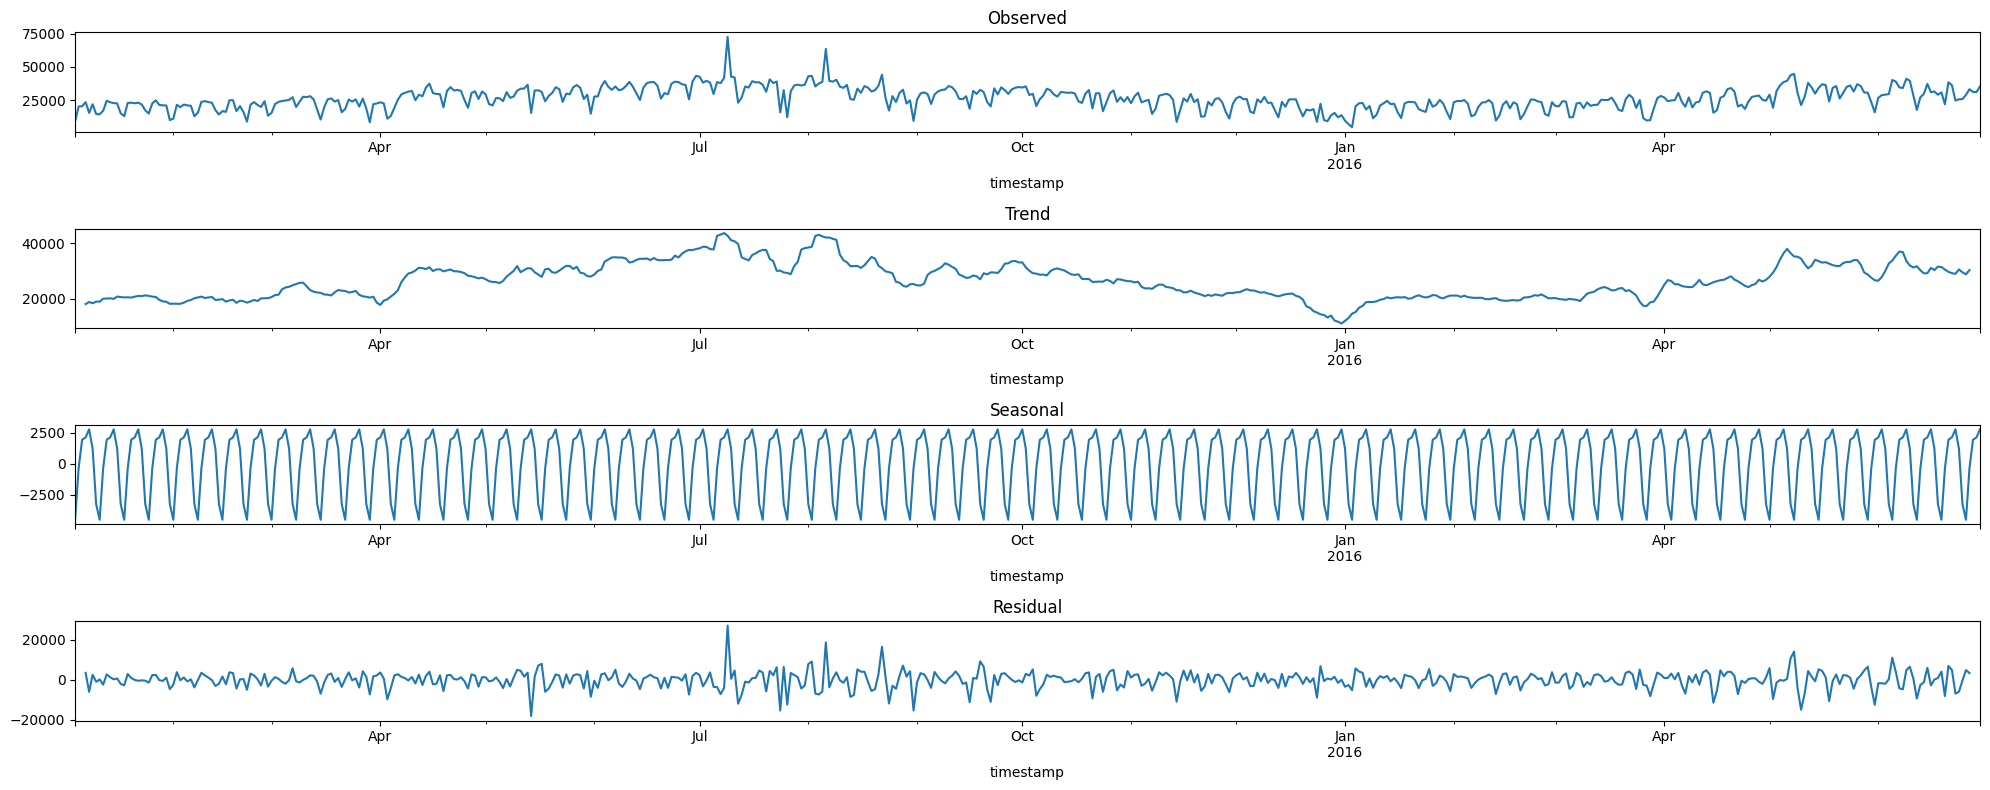

In [24]:
#Plot seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

fig_df = train_df.copy()
fig_df = fig_df.asfreq('D')
fig_df.index = pd.DatetimeIndex(fig_df.index.to_timestamp())
fig, axes = plt.subplots(4, 1, figsize=(20, 8))
seasonal_decompose = seasonal_decompose(fig_df['cnt'], model='additive')
seasonal_decompose.observed.plot(ax=axes[0], title='Observed')
seasonal_decompose.trend.plot(ax=axes[1], title='Trend')
seasonal_decompose.seasonal.plot(ax=axes[2], title='Seasonal')
seasonal_decompose.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()
plt.show()

There is clear seasonality in the data. Also, the data does not look stationary.

### Check for stationarity

In [25]:
def check_stationarity(data):
    print('Null Hypothesis: Presence of unit root (Data is not stationary)')
    print('Alternate Hypothesis: Absence of unit root (Data is stationary)')
    result = adfuller(data, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] > 0.05:
        print('Data is not stationary')
    else:
        print('Data is stationary')

check_stationarity(train_df['cnt'])

Null Hypothesis: Presence of unit root (Data is not stationary)
Alternate Hypothesis: Absence of unit root (Data is stationary)
ADF Statistic: -2.134764140765684
p-value: 0.2307674088038229
Data is not stationary


Hence, the models to be used should be able to handle seasonality and non-stationarity. SARIMAX might be a good choice. However, there are multiple seasonalities in the data which might be difficult to capture with SARIMAX. We will use XGBoost, LSTM and Prophet for this task. Let's still try SARIMAX and see how it performs.

# Models

## SARIMAX

- We will use Auto ARIMA to find the best parameter and not rely only on the ACF and PACF plots. However, ACF and PACF plots are useful to define the search space for Auto ARIMA. It is to note that Auto Arima leads to memory issue for high order models. Therefore, we will limit the search space.

In [26]:
from sarimax import SARIMAX_model, SARIMAX_metrics, SARIMAX_plot
sarimax_y_train, sarimax_y_test, sarimax_y_pred = SARIMAX_model(train_df, test_df)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=10891.160, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=10811.871, Time=2.67 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=10832.113, Time=2.38 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=13774.471, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=10809.875, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[52] intercept
Total fit time: 5.139 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  544
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -5386.937
Date:                Fri, 15 Mar 2024   AIC                          10809.875
Time:                        21:53:08   BIC                          10887.256
Sample:                    01-04-2015   HQIC                         10840.128
                         - 06-30-2016                            

- Ljung-Box:  P value is greater than 0.05. The residuals are not correlated.
- Jarque-Bera: P value is less than 0.05. The residuals are not normally distributed.
- Heteroskedasticity: P value is less than 0.05. The residuals are heteroskedastic.
- The residuals are not normally distributed and heteroskedastic. Therefore, the standard errors and confidence intervals might not be reliable.
- However, we will go through the variables to see the impact of each variable. Temperature and summer is significant and has a positive impact on the bike rentals. Wind speed, holiday, weekend and rain have a negative impact on the bike rentals. This is intuitive.

In [27]:
sarimax_test_metrics = SARIMAX_metrics(sarimax_y_test, sarimax_y_pred)
sarimax_test_metrics

{'RMSE': 5459.276770275171,
 'MAE': 4391.12893010616,
 'MAPE': 15.945418927204294,
 'R2': 0.6136945510956582}

MAPE is 16% and R-squared is 0.6 which means the model is able to explain only 60% of the variance in the data. This is not a good model.

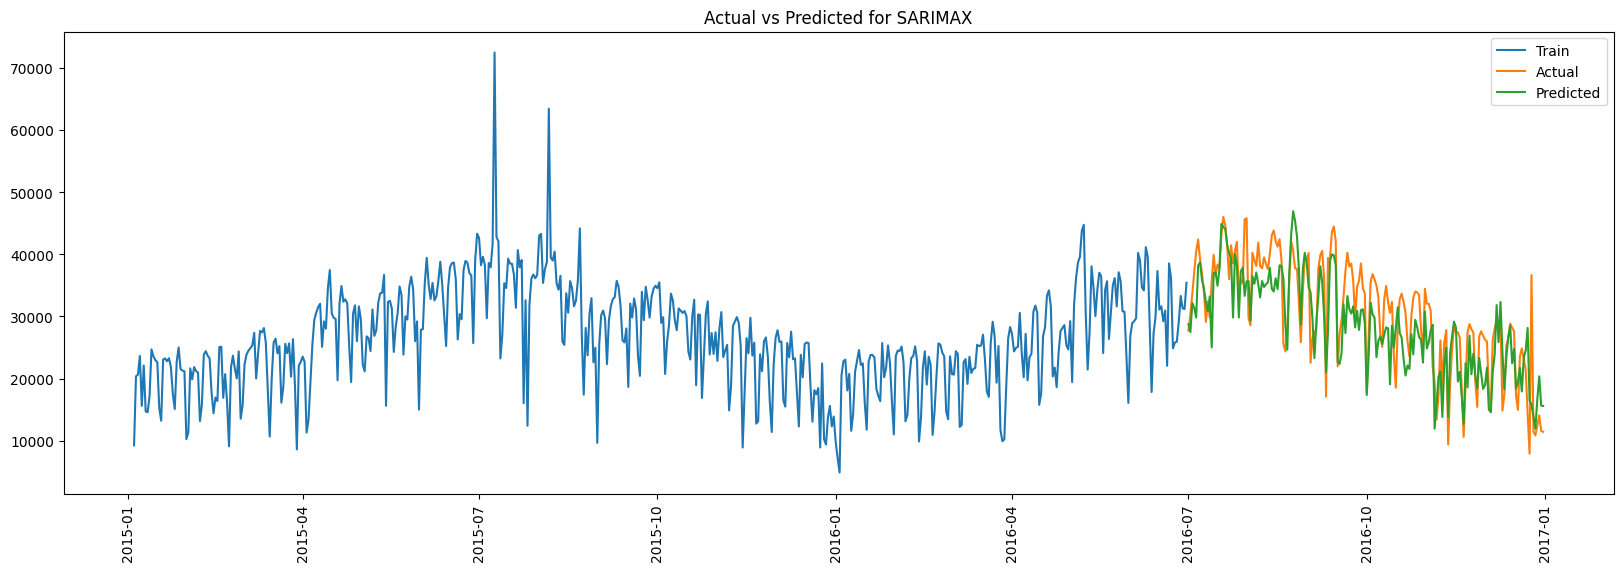

In [28]:
#Plot predictions
SARIMAX_plot(sarimax_y_train, sarimax_y_test, sarimax_y_pred)

## XGBoost

In [29]:
from XGBoost import xgboost_model, xgboost_metrics, xgboost_plot
xgboost_y_train, xgboost_y_test, xgboost_y_pred = xgboost_model(train_train_df, val_df, test_df)

Best parameters: {'n_estimators': 900, 'max_depth': 17, 'learning_rate': 0.016786197804558835, 'subsample': 0.1}


In [30]:
xgb_test_metrics = xgboost_metrics(xgboost_y_test, xgboost_y_pred)
xgb_test_metrics

{'RMSE': 4845.762058650972,
 'MAE': 3716.5702912703805,
 'MAPE': 13.886043762812475,
 'R2': 0.695641959395203}

MAPE is 13% and R-squared is 0.7. This is a better model than SARIMAX.

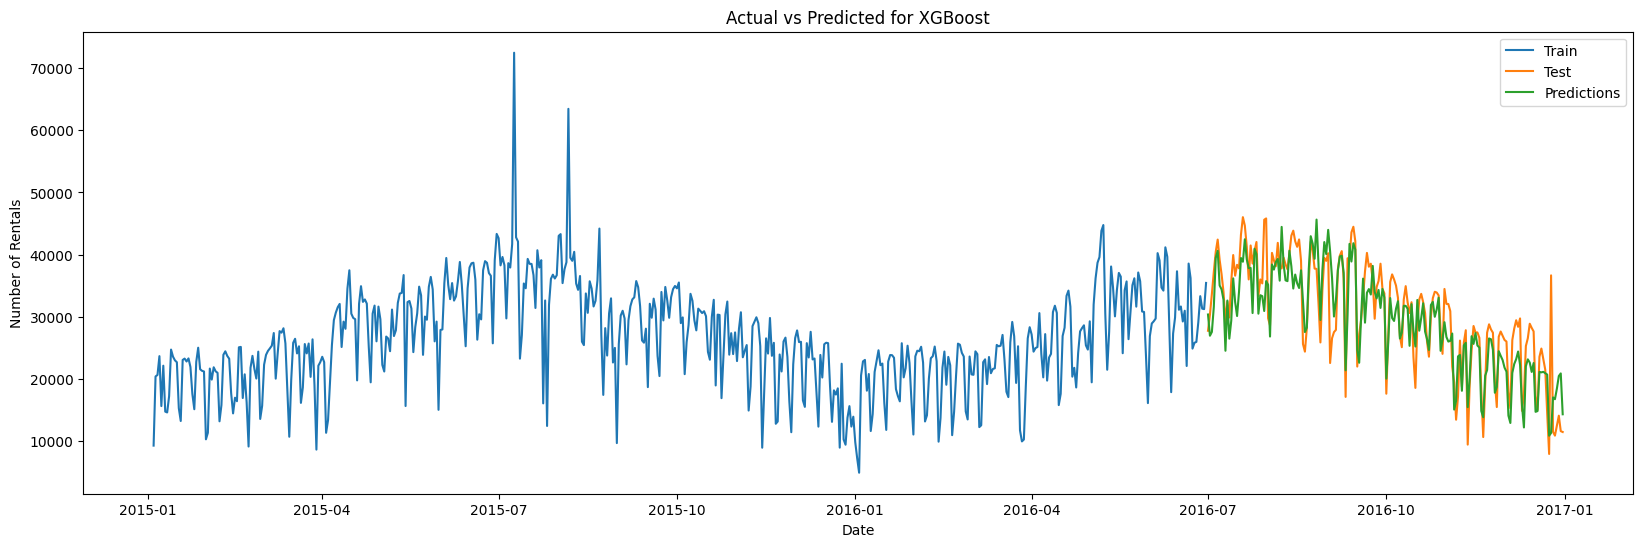

In [31]:
#Plot predictions
xgboost_plot(train_df, test_df, xgboost_y_pred)

## LSTM with encoder and decoder

In [32]:
from lstm_encode_decode import lstm_model, lstm_metrics, lstm_plot
lstm_y_test, lstm_y_pred = lstm_model(train_train_df,
                                        val_df,
                                        test_df,
                                        lookback=28,
                                        forecast_horizon=7,
                                        )

In [33]:
lstm_test_metrics = lstm_metrics(lstm_y_test, lstm_y_pred)
lstm_test_metrics

{'RMSE': 5445.508041006081,
 'MAE': 4195.278757863231,
 'MAPE': 14.404687654502771,
 'R2': 0.6017602844532698}

- MAPE is 14.4% and R-squared is 0.6. This did not perform well compared to XGBoost.

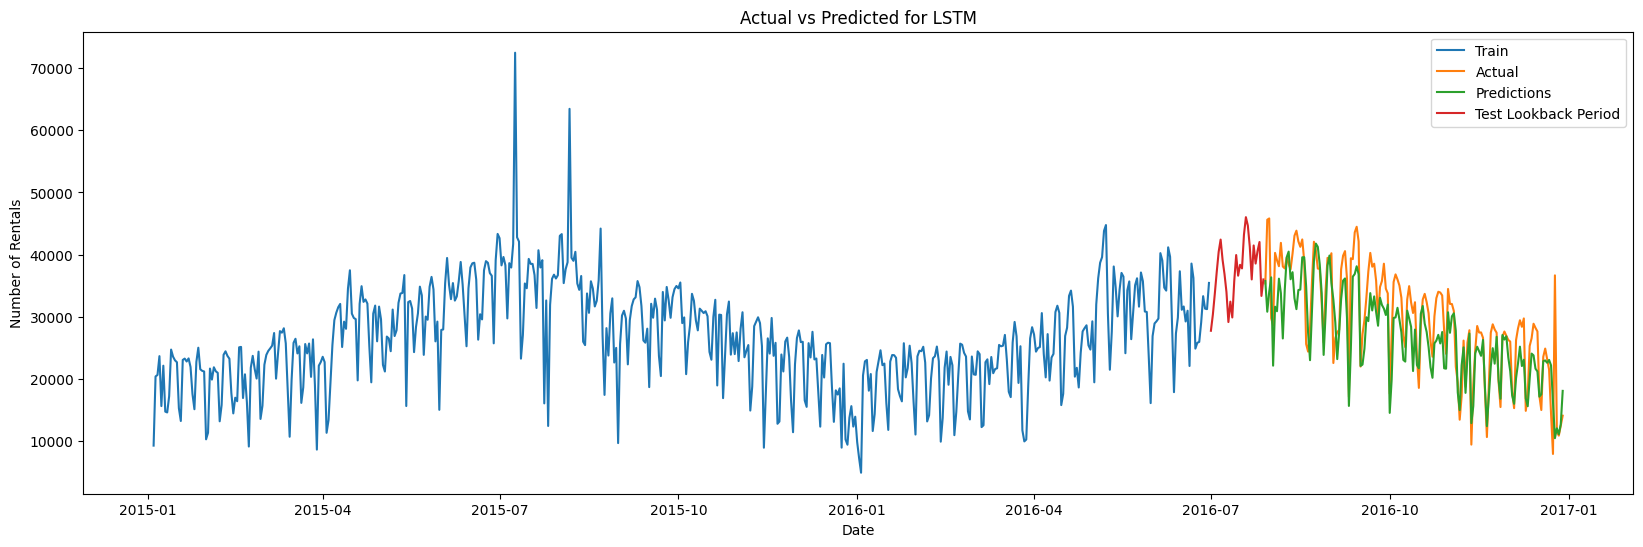

In [34]:
#Plot predictions
lstm_plot(train_df, test_df, lstm_y_pred, lookback=28)

## Prophet

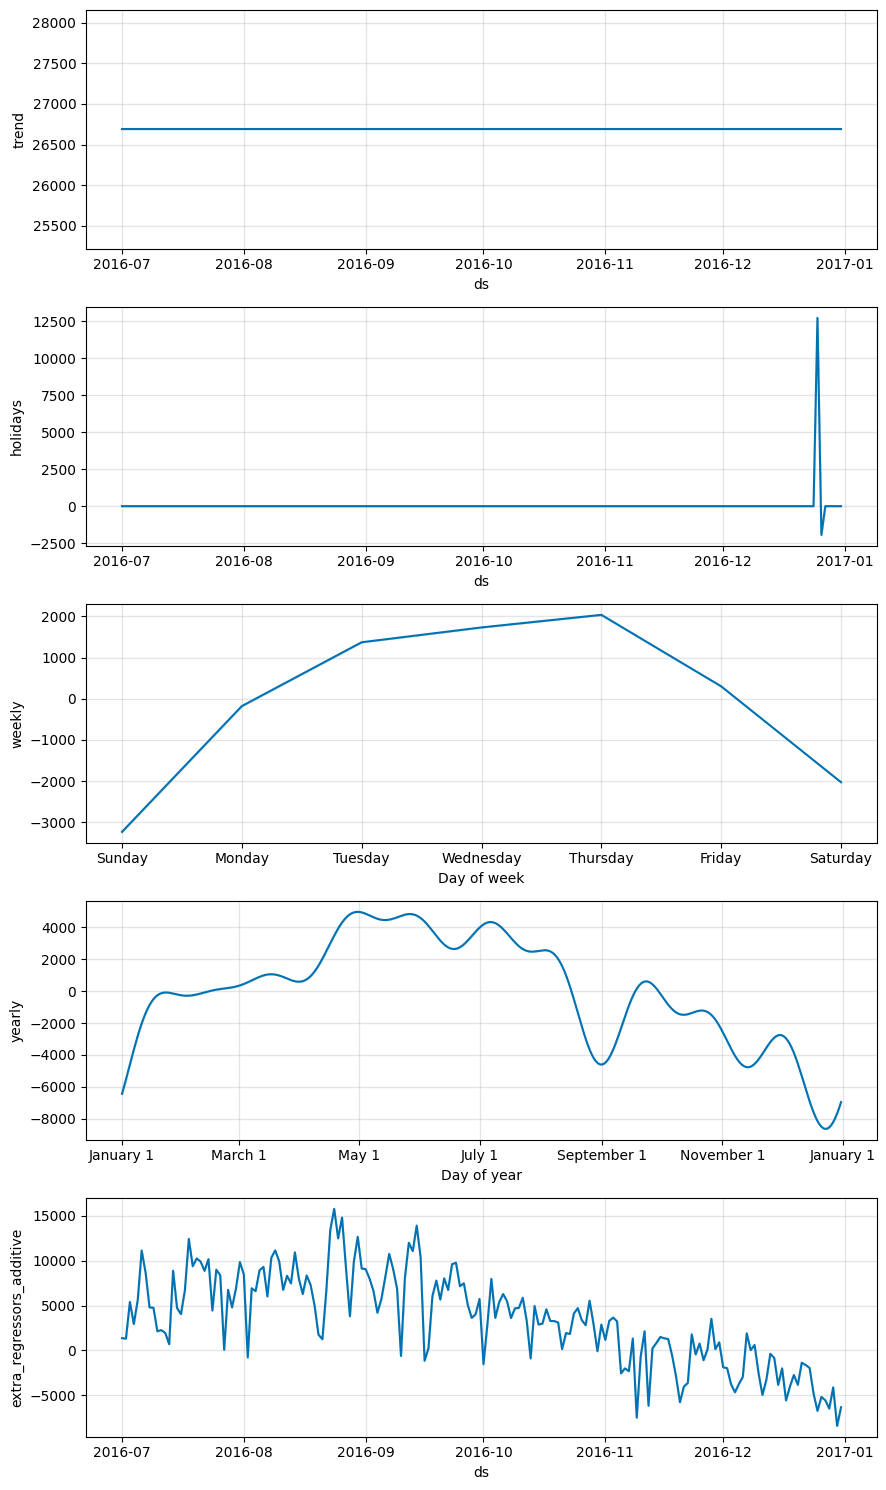

In [35]:
from Prophet import prophet_model, prophet_metrics, prophet_plot
prophet_test_df, prophet_y_pred = prophet_model(train_df, test_df)

- There is increase in bike rentals few days before end of the year holidays. During the holidays, there is a decrease in bike rentals.
- Weekly component plot shows that there is an increase in bike rentals during the weekdays.
- Yearly component plot shows that there is an increase in bike rentals during the summer and gradually decreases during the winter.

In [36]:
prophet_test_metrics = prophet_metrics(prophet_test_df, prophet_y_pred)
prophet_test_metrics

{'RMSE': 4266.527616431766,
 'MAE': 3345.124908364291,
 'MAPE': 11.801674978878033,
 'R2': 0.7640555688799952}

- MAPE is 12% and R-squared is 0.76. This is the best model among all the models.

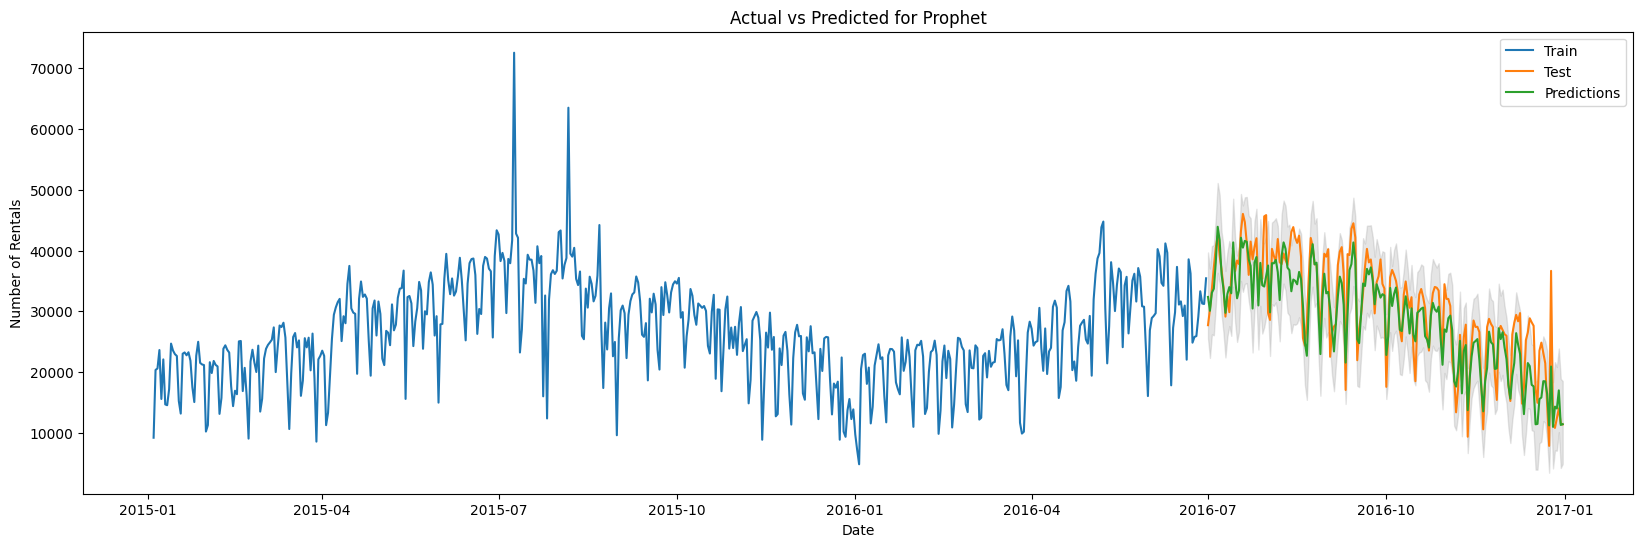

In [37]:
#Plot predictions
prophet_plot(train_df, test_df, prophet_y_pred)

# Export Results

In [38]:
# Export Results to csv
models = ['sarimax', 'xgboost', 'lstm', 'prophet']
metrics_dict = [sarimax_test_metrics, xgb_test_metrics, lstm_test_metrics, prophet_test_metrics]
#Create a dataframe to store the results
results = []
for model, metrics in zip(models, metrics_dict):
    results.append({'model': model, 'rmse': metrics['RMSE'], 'mae': metrics['MAE'], 'mape': metrics['MAPE'], 'r-squared': metrics['R2']})
results = pd.DataFrame(results)
results.to_csv('Results/metrics_bad_feature_engineering.csv', index=False)